In [19]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
# using Statistics
using Printf

In [20]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [21]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5e (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, 0.05)[i][1]
        CIr = confidence_interval(fit, 0.05)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [22]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


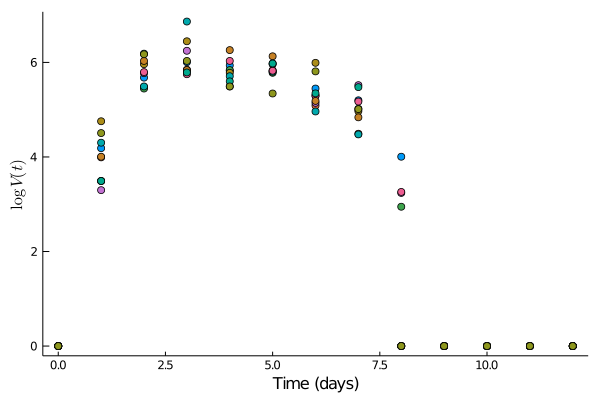

In [23]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Average of data

In [24]:
vdata_avg = mean(data, dims=1)[:]
vdata_std = std(data, dims=1)[:];

UndefVarError: UndefVarError: mean not defined

In [7]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

LoadError: UndefVarError: @L_str not defined

### Combined data

In [8]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
vvdata = reshape(data, 1, :)[:];

UndefVarError: UndefVarError: data not defined

In [9]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

LoadError: UndefVarError: @L_str not defined

### Combined data omitting last 3 observations

In [10]:
ttdata = reshape(repeat(tdata[1:end-3]', 10), 1, :)[:]
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];

UndefVarError: UndefVarError: data not defined

In [11]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

LoadError: UndefVarError: @L_str not defined

We'll use the combined data. But the average data shows similar results.

## Models

### Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [12]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VirusLoadFunction(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
namesVLF = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];

### Standard virus-target ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [13]:
VirusTargetODE = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, tend)
function VirusTargetModel(t, p)
    pars = (β = p[1], k = p[2], δ = p[3], K = p[4], p = p[5], c = p[6])
    prob = ODEProblem(VirusTargetODE, u0, tspan, pars)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[4, :])
end
namesVTM = ["β", "k", "δ", "K", "p", "c"];

## Fitting models to data

In [14]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,    5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fitVLF = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub);

UndefVarError: UndefVarError: curve_fit not defined

In [15]:
print_fit_values(fitVLF, par0, namesVLF)

UndefVarError: UndefVarError: print_fit_values not defined

In [16]:
#       β     , k     , δ     , K     , p     , c
par0 = [2.5e-4, 1.5e+0, 1.6e+6, 5.0e+4, 2.1e+0, 1.5e+1]
lb   = [0.0,    0.0,    0.0,    0.0,    0.0,    0.0]
ub   = [Inf,    Inf,    Inf,    Inf,    Inf,    Inf]
fitVTM = curve_fit(VirusTargetModel, ttdata, vvdata, par0, lower=lb, upper=ub);

UndefVarError: UndefVarError: curve_fit not defined

In [17]:
print_fit_values(fitVTM, par0, namesVTM)

UndefVarError: UndefVarError: print_fit_values not defined

In [18]:
tt = [range(0., tend, step=1e-2);]
pt = plot(ttdata, vvdata, seriestype=:scatter,
    label="Data set", grid=:off,
    xaxis = ("Time (days)", (0., 12.)),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
plot!(pt, tt, VirusLoadFunction(tt, fitVLF.param), lw=3, label="Virus load function")
plot!(pt, tt, VirusTargetModel(tt, fitVTM.param), lw=3, label="Virus-target model")
savefig(figdir*"Smith2018DataFit.png")
savefig(figdir*"Smith2018DataFit.pdf")
display(pt)

LoadError: UndefVarError: @L_str not defined